In [7]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_historical_price(symbol, days):
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart"
    params = {
        'vs_currency': 'eur',
        'days': days
    }
    response = requests.get(url, params=params)
    data = response.json()
    df_prices = pd.DataFrame(data['prices'], columns=['time', 'price'])
    df_market_caps = pd.DataFrame(data['market_caps'], columns=['time', 'market_cap'])
    df_total_volumes = pd.DataFrame(data['total_volumes'], columns=['time', 'total_volume'])

    df_prices['time'] = pd.to_datetime(df_prices['time'], unit='ms')
    df_market_caps['time'] = pd.to_datetime(df_market_caps['time'], unit='ms')
    df_total_volumes['time'] = pd.to_datetime(df_total_volumes['time'], unit='ms')

    df = pd.merge(df_prices, df_market_caps, on='time')
    df = pd.merge(df, df_total_volumes, on='time')

    return df

# Get the last 10 days of price data for Ethereum
df1 = get_historical_price('ethereum', 10)
print(df1)
# df2 = get_historical_price('bitcoin', 10)
# print(df2)

                       time        price    market_cap  total_volume
0   2024-05-01 19:06:21.100  2787.908375  3.399547e+11  2.056558e+10
1   2024-05-01 20:02:56.448  2727.004793  3.339671e+11  2.070368e+10
2   2024-05-01 21:03:20.730  2744.027070  3.349357e+11  2.002785e+10
3   2024-05-01 22:06:36.457  2775.526777  3.378291e+11  2.067323e+10
4   2024-05-01 23:05:33.384  2765.579239  3.379299e+11  1.995476e+10
..                      ...          ...           ...           ...
236 2024-05-11 15:00:26.997  2695.842802  3.237415e+11  9.389551e+09
237 2024-05-11 16:01:51.620  2715.377245  3.265454e+11  8.549839e+09
238 2024-05-11 17:02:48.946  2710.175920  3.252809e+11  7.759019e+09
239 2024-05-11 18:06:47.002  2713.264597  3.262754e+11  7.048430e+09
240 2024-05-11 18:43:39.000  2719.403283  3.268262e+11  6.877644e+09

[241 rows x 4 columns]


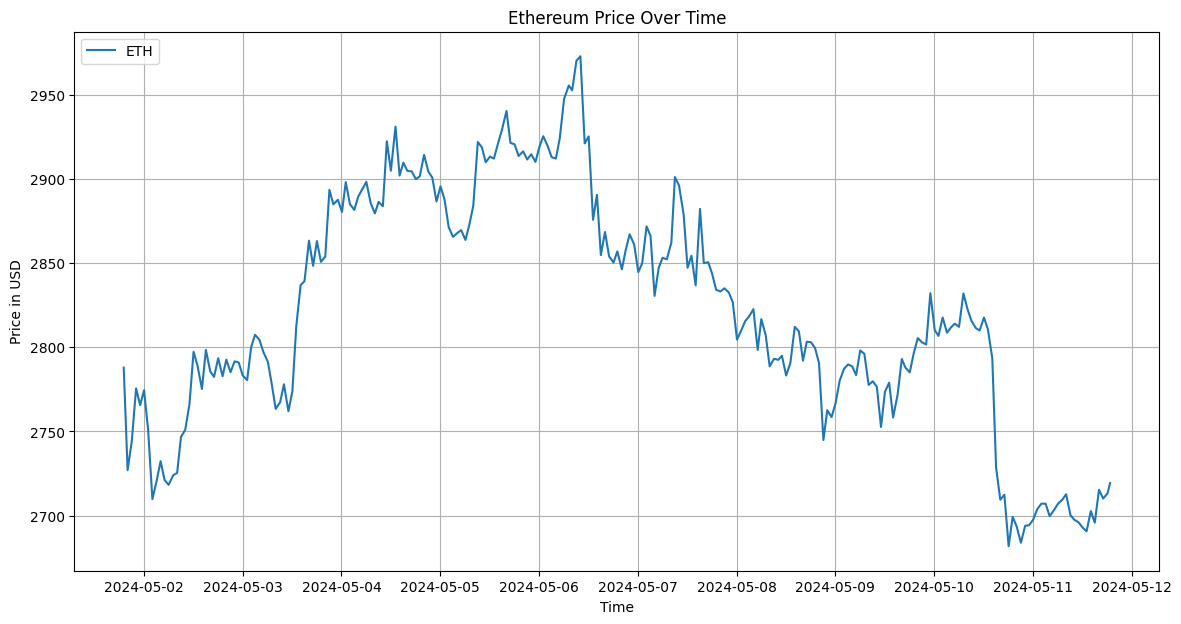

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df1['time'], df1['price'], label='ETH')
# plt.plot(df2['time'], df2['price'], color='red', label='BTC')  # new line
# plt.plot(df3['time'], df3['price'], color='red', label='ETH')  # new line
plt.legend(loc='upper left')
plt.title('Ethereum Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.grid(True)
plt.show()


In [ ]:
def calculate_rolling_average(df, window_size):
    df['rolling_avg_price'] = df['price'].rolling(window=window_size).mean()
    return df

window_size = 30
df1_rolling = calculate_rolling_average(df1, window_size)
# df2 = calculate_rolling_average(df2, window_size)

print(df1_rolling)
# print(df2)


In [ ]:
# TOPS AND BOTTOMS
import numpy as np
from scipy.signal import argrelextrema

def calculate_extrema(df, window_size):
    # Calculate rolling max and min
    df['rolling_max_price'] = df['price'].rolling(window=window_size).max()
    df['rolling_min_price'] = df['price'].rolling(window=window_size).min()

    # Find the indices of the maxima and minima
    maxima_indices = argrelextrema(df['price'].values, np.greater)[0]
    minima_indices = argrelextrema(df['price'].values, np.less)[0]

    # Create new columns for maxima and minima
    df['maxima'] = np.nan
    df['minima'] = np.nan
    df.loc[maxima_indices, 'maxima'] = df['price'].loc[maxima_indices]
    df.loc[minima_indices, 'minima'] = df['price'].loc[minima_indices]

    return df

window_size = 30
df1_extrema = calculate_extrema(df1, window_size)
# df2_extrema = calculate_extrema(df2, window_size)

print(df1_extrema)
# print(df2_extrema)


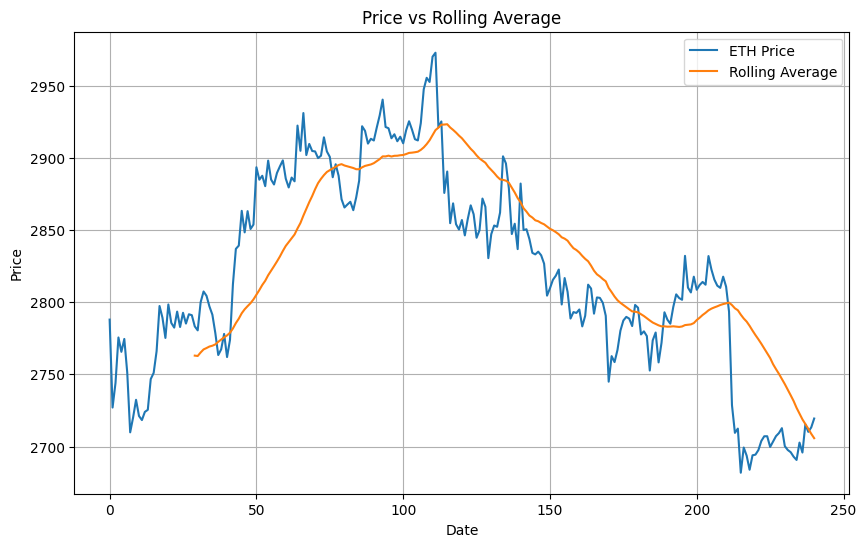

In [13]:
import matplotlib.pyplot as plt

# Assuming you have 'date' as the index of your DataFrame
plt.figure(figsize=(10, 6))
plt.plot(df1.index, df1['price'], label='ETH Price')
plt.plot(df1_rolling.index, df1_rolling['rolling_avg_price'], label='Rolling Average')
# plt.plot(df1_double_top.index, df1_double_top['bearish_double_top'], label='Bearish double top')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price vs Rolling Average')
plt.legend()
plt.grid(True)
plt.show()


# NEW

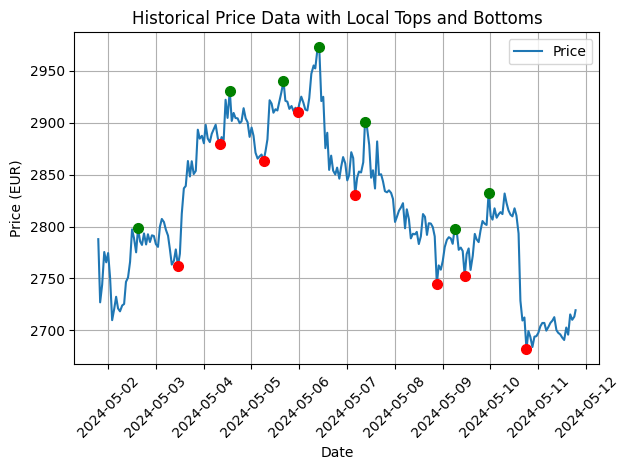

In [15]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_historical_price(symbol, days):
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart"
    params = {
        'vs_currency': 'eur',
        'days': days
    }
    response = requests.get(url, params=params)
    data = response.json()
    df_prices = pd.DataFrame(data['prices'], columns=['time', 'price'])
    df_prices['time'] = pd.to_datetime(df_prices['time'], unit='ms')
    return df_prices

def rw_top(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    top = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] > v or data[k - i] > v:
            top = False
            break
    
    return top

def rw_bottom(data: np.array, curr_index: int, order: int) -> bool:
    if curr_index < order * 2 + 1:
        return False

    bottom = True
    k = curr_index - order
    v = data[k]
    for i in range(1, order + 1):
        if data[k + i] < v or data[k - i] < v:
            bottom = False
            break
    
    return bottom

def rw_extremes(data: np.array, order:int):
    tops = []
    bottoms = []
    for i in range(len(data)):
        if rw_top(data, i, order):
            top = [i, i - order, data[i - order]]
            tops.append(top)
        
        if rw_bottom(data, i, order):
            bottom = [i, i - order, data[i - order]]
            bottoms.append(bottom)
    
    return tops, bottoms

if __name__ == "__main__":
    # Fetch historical price data
    df_prices = get_historical_price('ethereum', 10)
    price_data = df_prices['price'].to_numpy()

    # Find local tops and bottoms
    tops, bottoms = rw_extremes(price_data, 10)

    # Plot historical price data with tops and bottoms
    plt.plot(df_prices['time'], df_prices['price'], label='Price')
    for top in tops:
        plt.plot(df_prices['time'][top[1]], top[2], marker='o', color='green', markersize=7)
    for bottom in bottoms:
        plt.plot(df_prices['time'][bottom[1]], bottom[2], marker='o', color='red', markersize=7)

    plt.xlabel('Date')
    plt.ylabel('Price (EUR)')
    plt.title('Historical Price Data with Local Tops and Bottoms')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [16]:
def find_hs_patterns(data: np.array, order:int, early_find:bool = False):
    assert(order >= 1)
    
    last_is_top = False
    recent_extrema = deque(maxlen=5)
    recent_types = deque(maxlen=5)  # -1 for bottoms 1 for tops

    # Lock variables to prevent finding the same pattern multiple times
    hs_lock = False
    ihs_lock = False

    ihs_patterns = []  # Inverted (bullish)
    hs_patterns = []   # Regular (bearish)

    for i in range(len(data)):

        if rw_top(data, i, order):
            recent_extrema.append(i - order)
            recent_types.append(1)
            ihs_lock = False
            last_is_top = True
        
        if rw_bottom(data, i, order):
            recent_extrema.append(i - order)
            recent_types.append(-1)
            hs_lock = False
            last_is_top = False

        if len(recent_extrema) < 5:
            continue
        
        hs_alternating = True
        ihs_alternating = True
        
        if last_is_top:
            for j in range(2, 5):
                if recent_types[j] == recent_types[j - 1]: 
                    ihs_alternating = False
            
            for j in range(1, 4):
                if recent_types[j] == recent_types[j - 1]: 
                    hs_alternating = False
            
            ihs_extrema = list(recent_extrema)[1:5]
            hs_extrema = list(recent_extrema)[0:4]
        else:
            
            for j in range(2, 5):
                if recent_types[j] == recent_types[j - 1]: 
                    hs_alternating = False
            
            for j in range(1, 4):
                if recent_types[j] == recent_types[j - 1]: 
                    ihs_alternating = False
            
            ihs_extrema = list(recent_extrema)[0:4]
            hs_extrema = list(recent_extrema)[1:5]
        
        if ihs_lock or not ihs_alternating:
            ihs_pat = None
        else:
            ihs_pat = check_ihs_pattern(ihs_extrema, data, i, early_find)

        if hs_lock or not hs_alternating:
            hs_pat = None
        else:
            hs_pat = check_hs_pattern(hs_extrema, data, i, early_find)

        if hs_pat is not None:
            hs_lock = True
            hs_patterns.append(hs_pat)
        
        if ihs_pat is not None:
            ihs_lock = True
            ihs_patterns.append(ihs_pat)

    return hs_patterns, ihs_patterns


In [21]:
from collections import deque

In [22]:
if __name__ == "__main__":
    # Fetch historical price data
    df_prices = get_historical_price('ethereum', 10)
    price_data = df_prices['price'].to_numpy()

    # Find local tops and bottoms
    tops, bottoms = rw_extremes(price_data, 10)

    # Find head and shoulders patterns
    hs_patterns, ihs_patterns = find_hs_patterns(price_data, 10)

    # Plot historical price data with detected tops and bottoms
    plt.plot(df_prices['time'], df_prices['price'], label='Price')
    for top in tops:
        plt.plot(df_prices['time'][top[1]], top[2], marker='o', color='green', markersize=7)
    for bottom in bottoms:
        plt.plot(df_prices['time'][bottom[1]], bottom[2], marker='o', color='red', markersize=7)

    # Plot head and shoulders patterns
    for hs_pattern in hs_patterns:
        plot_hs(df_prices, hs_pattern)

    plt.xlabel('Date')
    plt.ylabel('Price (EUR)')
    plt.title('Historical Price Data with Local Tops and Bottoms and Head & Shoulders Patterns')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

NameError: name 'check_ihs_pattern' is not defined

In [1]:
import requests
import pandas as pd

def get_historical_price(symbol, days):
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart"
    params = {
        'vs_currency': 'eur',
        'days': days
    }
    response = requests.get(url, params=params)
    data = response.json()
    df_prices = pd.DataFrame(data['prices'], columns=['time', 'price'])
    df_prices['time'] = pd.to_datetime(df_prices['time'], unit='ms')
    
    return df_prices

# Get the last 10 days of price data for Ethereum
df_ethereum = get_historical_price('ethereum', 10)

# Rename columns for clarity
df_ethereum.columns = ['date', 'price']

# Shift price data to obtain open, high, low, and close prices
df_ethereum['open'] = df_ethereum['price'].shift(1)
df_ethereum['close'] = df_ethereum['price']
df_ethereum['high'] = df_ethereum['price'].rolling(window=24, min_periods=1).max()
df_ethereum['low'] = df_ethereum['price'].rolling(window=24, min_periods=1).min()

# Drop unnecessary columns
df_ethereum = df_ethereum.drop(columns=['price'])

# Drop NaN values
df_ethereum = df_ethereum.dropna()

print(df_ethereum)


                       date         open        close         high  \
1   2024-05-01 21:03:20.730  2727.004793  2744.027070  2744.027070   
2   2024-05-01 22:06:36.457  2744.027070  2775.526777  2775.526777   
3   2024-05-01 23:05:33.384  2775.526777  2765.579239  2775.526777   
4   2024-05-02 00:02:49.923  2765.579239  2774.508050  2775.526777   
5   2024-05-02 01:01:22.564  2774.508050  2751.212197  2775.526777   
..                      ...          ...          ...          ...   
236 2024-05-11 16:01:51.620  2695.842802  2715.377245  2715.377245   
237 2024-05-11 17:02:48.946  2715.377245  2710.175920  2715.377245   
238 2024-05-11 18:06:47.002  2710.175920  2713.264597  2715.377245   
239 2024-05-11 19:04:36.124  2713.264597  2720.296735  2720.296735   
240 2024-05-11 19:14:21.000  2720.296735  2717.784537  2720.296735   

             low  
1    2727.004793  
2    2727.004793  
3    2727.004793  
4    2727.004793  
5    2727.004793  
..           ...  
236  2681.871854  
237  26